In [131]:
import pandas as pd 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore')

## **讀取/整理資料**

In [115]:
future_data = pd.read_parquet('future.parquet').sort_values('datetime').reset_index(drop=True)
print(list(set(future_data['symbol'])))

['ZMTXA', 'ZCDFA', 'ZTXA', 'ZQFFA']


In [116]:
# 大台指期 ZTXA
symbol = 'ZTXA'
symbol_data = future_data[(future_data['symbol']==symbol)&(future_data['datetime']>=datetime(2008,1,1))]
symbol_data

,symbol,datetime,expiry_month,open,high,low,close,settle_price,returns,volume,open_interest
4068,ZTXA,2008-01-02,2008-01-01,8450.0,8506.0,8271.0,8282.0,8283.0,-0.023577,61525,38463
4070,ZTXA,2008-01-03,2008-01-01,8200.0,8229.0,8083.0,8143.0,8143.0,-0.016902,80492,40837
4072,ZTXA,2008-01-04,2008-01-01,8100.0,8245.0,8030.0,8209.0,8210.0,0.008228,72552,41964
4074,ZTXA,2008-01-07,2008-01-01,7951.0,7999.0,7800.0,7833.0,7833.0,-0.045920,72476,48970
4075,ZTXA,2008-01-08,2008-01-01,7840.0,7964.0,7815.0,7916.0,7918.0,0.010852,55646,50074
...,...,...,...,...,...,...,...,...,...,...,...
16483,ZTXA,2024-06-07,2024-06-01,21839.0,21908.0,21781.0,21897.0,21894.0,0.000960,69801,80182
16487,ZTXA,2024-06-11,2024-06-01,21920.0,21970.0,21783.0,21798.0,21801.0,-0.004248,94289,75320
16489,ZTXA,2024-06-12,2024-06-01,21829.0,22063.0,21790.0,22046.0,22046.0,0.011238,95615,78963
16495,ZTXA,2024-06-13,2024-06-01,22308.0,22473.0,22207.0,22323.0,22325.0,0.012655,114828,75421


## **Var**

In [117]:
confident_level = 0.95
future_return = symbol_data['returns']
var = future_return.quantile(1-confident_level)
margin = -var*3
print(f'在{confident_level*100}％的信心水平下，保證金應為資金:{round(margin*100,4)}％')

在95.0％的信心水平下，保證金應為資金:5.9999％


#### **回測**

In [118]:
def backtest(data,confident_level,window_collect,multiplier,use_ratio):
    # window_collect 收集資料的天數
    # use_ratio 期望使用到的保證金佔資金比例高於x%

    backtest_data = data.dropna()
    backtest_data['var'] = backtest_data['returns'].rolling(window_collect).apply(lambda x: -np.quantile(x,1-confident_level))
    backtest_data['Margin'] = backtest_data['var']*multiplier

    force_date = []
    waste_date = []
    max_waste = 0
    for i in range(window_collect,len(backtest_data)-1):
        daily_return = backtest_data.iloc[i]['returns']
        if daily_return<0:
            if -daily_return>backtest_data['Margin'].iloc[i]:
                force_date.append(backtest_data.iloc[i]['datetime'])
            else:
                waste_asset = backtest_data['Margin'].iloc[i] + daily_return
                if waste_asset/backtest_data['Margin'].iloc[i]>(1-use_ratio):
                    waste_date.append(backtest_data.iloc[i]['datetime'])
                if waste_asset> max_waste:
                    max_waste= waste_asset
    # print(f'Max of waste : {max_waste_asset}')
    return backtest_data,force_date,waste_date
    

In [119]:
count = pd.DataFrame(columns=['Parameter','Forced','Underutilized'])
for multiplier in tqdm(range(10,45,5)):
    for window_collect in range(30,390,30):
        backtest_data,force_date,waste_date = backtest(symbol_data,confident_level=0.95,window_collect=window_collect,multiplier=multiplier/10,use_ratio=0.7)
        count.loc[len(count)] = [str([multiplier/10,window_collect]),len(force_date),len(waste_date)]
count.head(3)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


,Parameter,Forced,Underutilized
0,"[1.0, 30]",295,1248
1,"[1.0, 60]",216,1315
2,"[1.0, 90]",244,1350


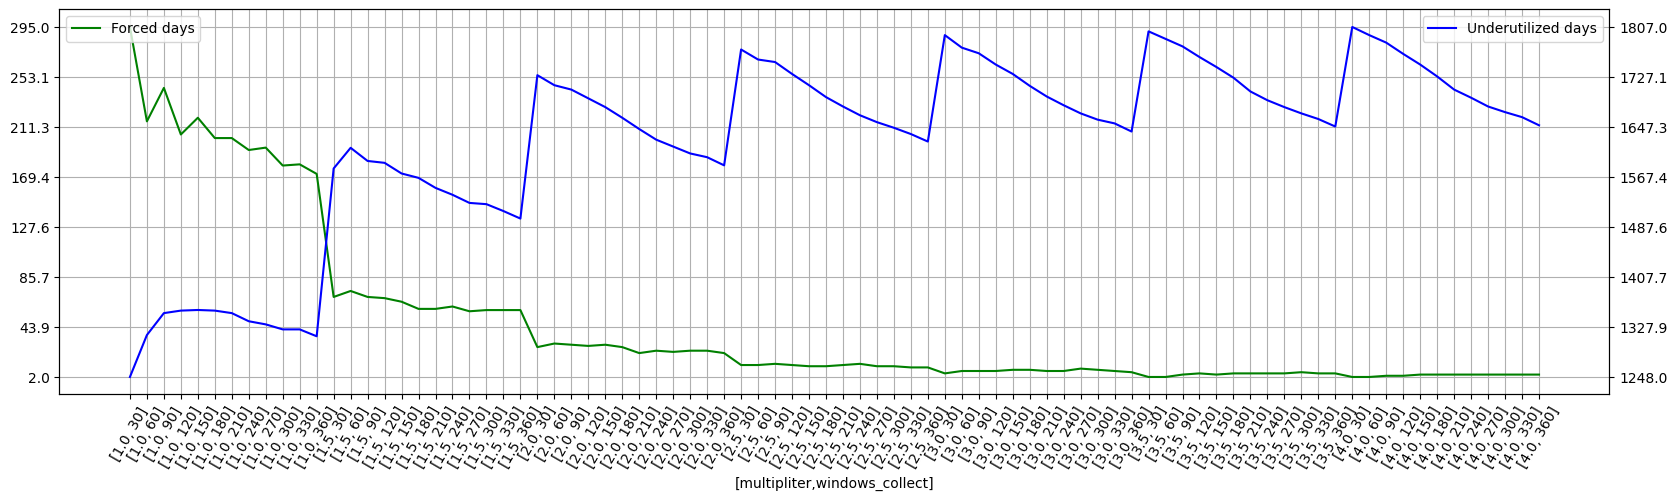

In [120]:
def draw_compare_plot(df,x,y1,y2,x_label='[multipliter,windows_collect]'):
    fig, ax1 = plt.subplots(figsize=(20, 5))
    plt.xticks(rotation=60)
    ax2 = ax1.twinx()
    ax1.plot(df[x],df[y1], 'g-',label = f'{y1} days')
    ax2.plot(df[x],df[y2], 'b-', label = f'{y2} days')
    ax1.set_xlabel(x_label)
    ax2.legend(loc = 'upper right')
    ax1.legend(loc = 'upper left')
    ax1.set_yticks(np.linspace(min(df[y1]),max(df[y1]),8))
    ax2.set_yticks(np.linspace(min(df[y2]),max(df[y2]),8))
    ax1.grid(True)
    plt.show()
draw_compare_plot(count,'Parameter','Forced','Underutilized')

Days of forced liquidation : 7
Days of assets are Underutilized : 1653


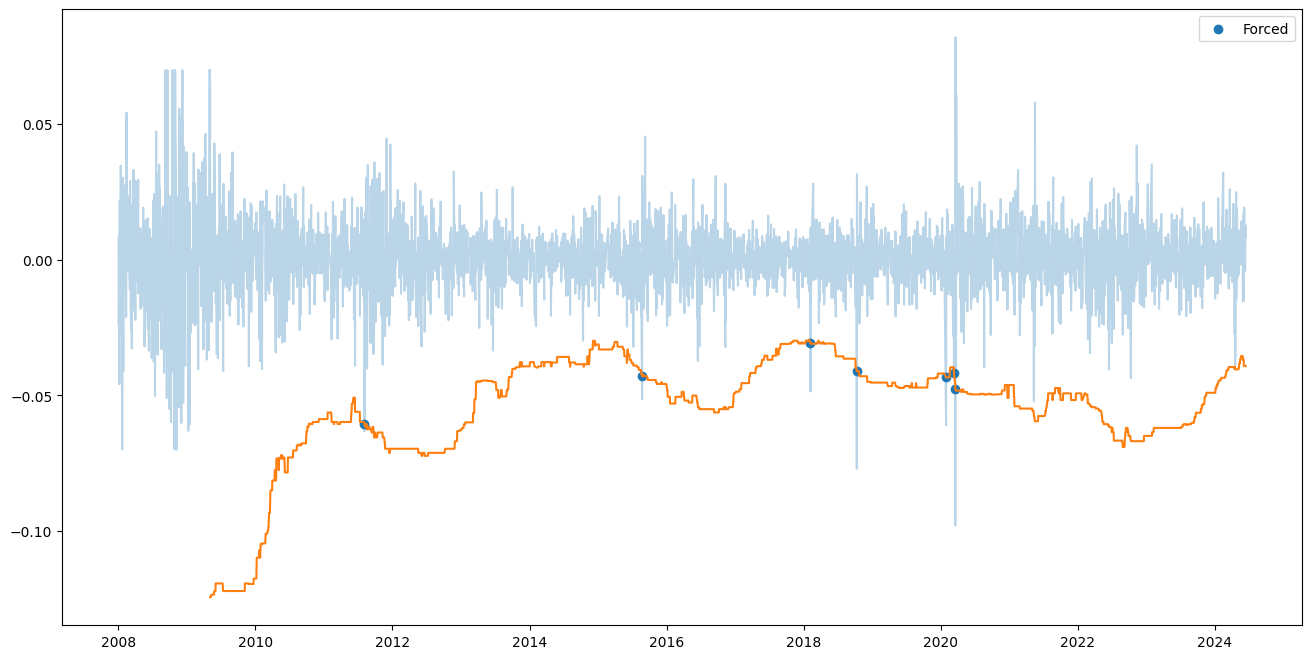

In [128]:
def draw_plot(df,x1_list,x2_list,show_type:str):
    '''
    df : DataFrame, input basktest data
    show_type : str ,input the type you want the plot show : both/force/waste

    '''
    plt.figure(figsize=(16,8))
    plt.plot(df['datetime'],df['returns'],alpha=0.3)
    plt.plot(df['datetime'],-df['Margin'])
    if show_type == 'both':
        plt.scatter(df[df['datetime'].isin(x1_list)]['datetime'],-df[df['datetime'].isin(x1_list)]['Margin'],label = 'Forced')
        plt.scatter(df[df['datetime'].isin(x2_list)]['datetime'],-df[df['datetime'].isin(x2_list)]['Margin'],label = 'Underutilized',color='green',s=8)
    elif show_type == 'force':
        plt.scatter(df[df['datetime'].isin(x1_list)]['datetime'],-df[df['datetime'].isin(x1_list)]['Margin'],label = 'Forced')
    else:
        plt.scatter(df[df['datetime'].isin(x2_list)]['datetime'],-df[df['datetime'].isin(x2_list)]['Margin'],label = 'Underutilized',color='green',s=8)
    plt.legend()

backtest_data,force_date,waste_date = backtest(symbol_data,confident_level=0.95,window_collect=330,multiplier=3,use_ratio=0.7)
print(f'Days of forced liquidation : {len(force_date)}')
print(f'Days of assets are Underutilized : {len(waste_date)}')
draw_plot(backtest_data,force_date,waste_date,'force')

### **蒙地卡羅**

In [122]:
def monte_backtest(df,confident_level,window_collect,multiplier,use_ratio,simulate_n=1000):
    backtest_data = df.dropna()

    vars = []
    margins = []
    vars.extend([np.nan]*window_collect)
    margins.extend([np.nan]*window_collect)

    for i in range(len(backtest_data) - window_collect):
        window_data = backtest_data['returns'].iloc[i:i+window_collect]
        mean_return = window_data.mean()
        std_return = window_data.std()
        monte_returns = np.random.normal(mean_return, std_return, simulate_n)
        var = np.quantile(monte_returns, 1 - confident_level)
        margin = -var * multiplier
        vars.append(var)
        margins.append(margin)
    backtest_data['Var'] = vars
    backtest_data['Margin'] = margins

    force_date = []
    waste_date = []
    max_waste_asset = 0
    for i in range(window_collect,len(backtest_data)-1):
        daily_return = backtest_data.iloc[i]['returns']
        if daily_return<0:
            if -daily_return>backtest_data['Margin'].iloc[i]:
                force_date.append(backtest_data.iloc[i]['datetime'])
            else:
                waste_asset = backtest_data['Margin'].iloc[i] + daily_return
                if waste_asset/backtest_data['Margin'].iloc[i]>(1-use_ratio):
                    waste_date.append(backtest_data.iloc[i]['datetime'])
                if waste_asset> max_waste_asset:
                    max_waste_asset= waste_asset
    return backtest_data,force_date,waste_date

In [123]:
count_monte = pd.DataFrame(columns=['Parameter','Forced','Underutilized'])
for multiplier in tqdm(range(10,45,5)):
    for window_collect in range(30,390,30):
        backtest_data,force_date,waste_date = monte_backtest(symbol_data,confident_level=0.95,window_collect=window_collect,multiplier=multiplier/10,use_ratio=0.7,simulate_n=1000)
        count_monte.loc[len(count_monte)] = [str([multiplier/10,window_collect]),len(force_date),len(waste_date)]
count_monte.head(3)

100%|██████████| 7/7 [01:18<00:00, 11.25s/it]


,Parameter,Forced,Underutilized
0,"[1.0, 30]",261,1325
1,"[1.0, 60]",238,1354
2,"[1.0, 90]",234,1362


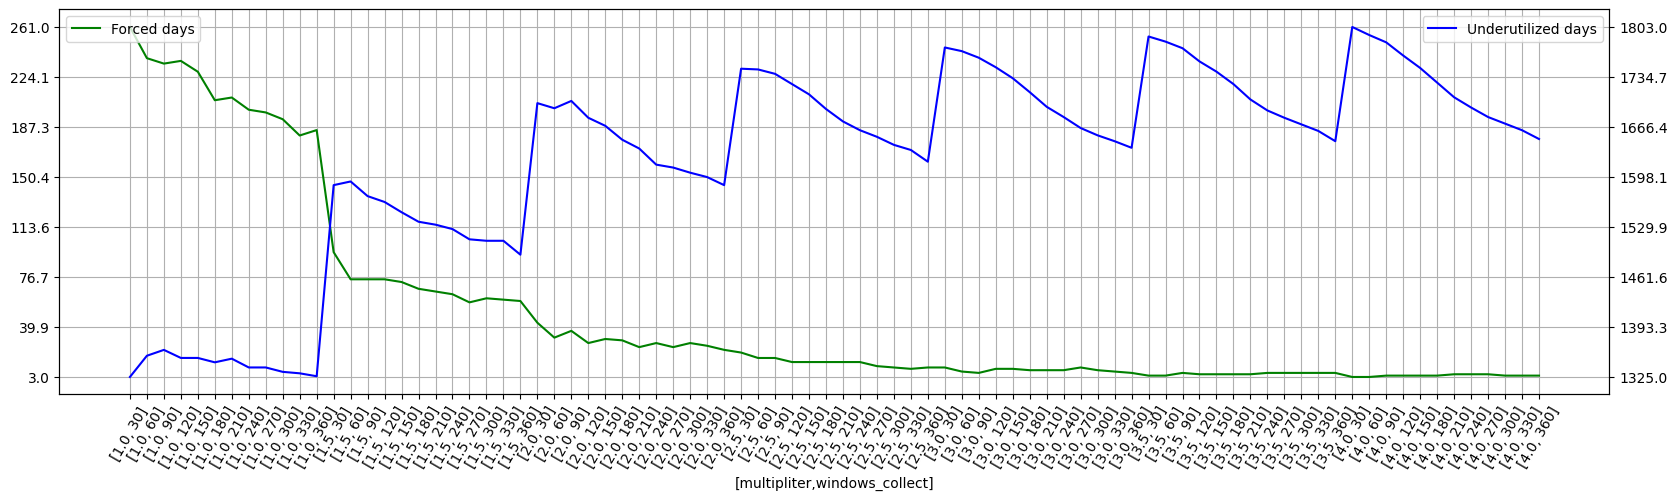

In [124]:
draw_compare_plot(count_monte,'Parameter','Forced','Underutilized')

Days of forced liquidation : 7
Days of assets are Underutilized : 1647


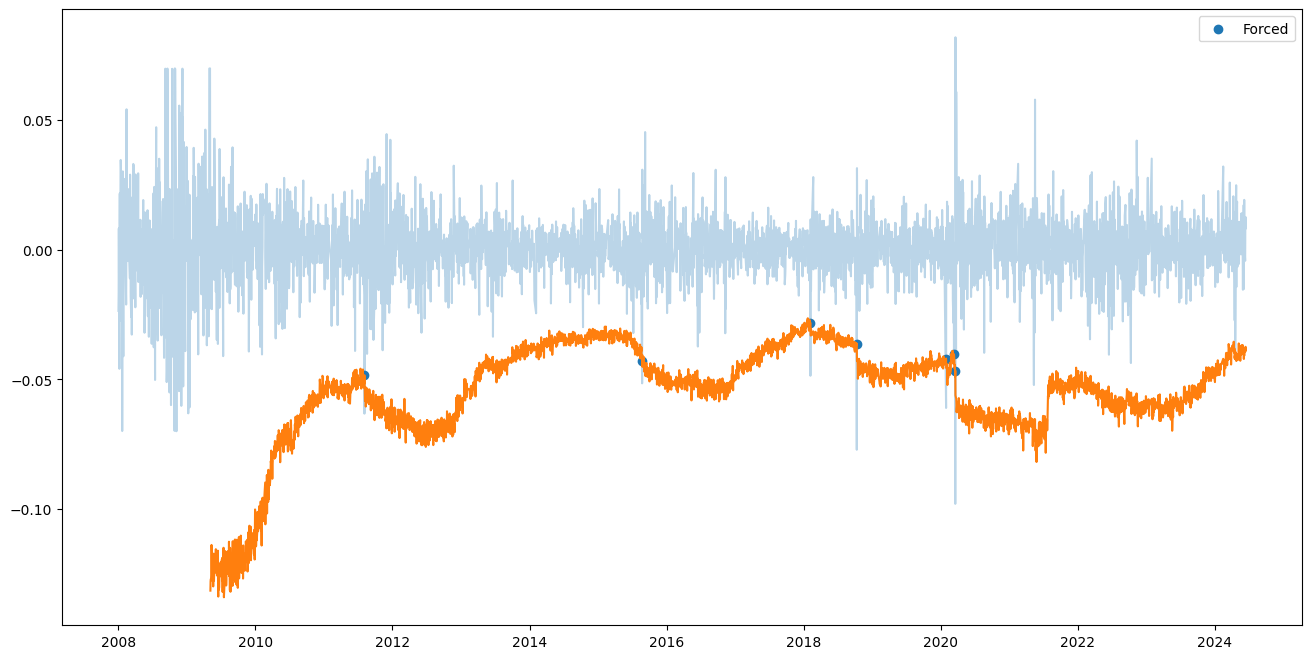

In [129]:
backtest_data,force_date,waste_date = monte_backtest(symbol_data,confident_level=0.95,window_collect=330,multiplier=3,use_ratio=0.7,simulate_n=1000)
print(f'Days of forced liquidation : {len(force_date)}')
print(f'Days of assets are Underutilized : {len(waste_date)}')
draw_plot(backtest_data,force_date,waste_date,'force')

### **EWMA**

In [150]:
def ewma(x,alpha):
    return x.ewm(alpha=alpha, adjust=False).mean().iloc[-1]

def ewma_backtest(df,confident_level=0.95,multiplier=3,window_collect=30,alpha=0.05,use_ratio=0.7):
    z = norm.ppf(confident_level)
    backtest_data = df.dropna()
    backtest_data['return^2'] = backtest_data['returns']**2
    backtest_data['EWMA_var'] = backtest_data['return^2'].rolling(window=window_collect).apply(lambda x: ewma(x,alpha))
    backtest_data['EWMA_vol'] = np.sqrt(backtest_data['EWMA_var'])
    backtest_data['Var']= backtest_data['EWMA_vol']*z
    backtest_data['Margin'] = backtest_data['Var']*multiplier

    force_date = []
    waste_date = []
    max_waste_asset = 0
    for i in range(window_collect,len(backtest_data)-1):
        daily_return = backtest_data.iloc[i]['returns']
        if daily_return<0:
            if -daily_return>backtest_data['Margin'].iloc[i]:
                force_date.append(backtest_data.iloc[i]['datetime'])
            else:
                waste_asset = backtest_data['Margin'].iloc[i] + daily_return
                if waste_asset/backtest_data['Margin'].iloc[i]>(1-use_ratio):
                    waste_date.append(backtest_data.iloc[i]['datetime'])
                if waste_asset> max_waste_asset:
                    max_waste_asset= waste_asset
    return backtest_data,force_date,waste_date

In [157]:
count_ewma = pd.DataFrame(columns=['Parameter','Forced','Underutilized'])
for multiplier in tqdm(range(10,45,5)):
    for window_collect in range(30,390,30):
        backtest_data,force_date,waste_date = ewma_backtest(symbol_data,confident_level=0.95,multiplier=multiplier/10,window_collect=window_collect,alpha=0.05,use_ratio=0.7)
        count_ewma.loc[len(count_ewma)] = [str([multiplier/10,window_collect]),len(force_date),len(waste_date)]
count_ewma.head(3)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:43<00:00,  6.15s/it]


,Parameter,Forced,Underutilized
0,"[1.0, 30]",220,1347
1,"[1.0, 60]",199,1381
2,"[1.0, 90]",198,1374


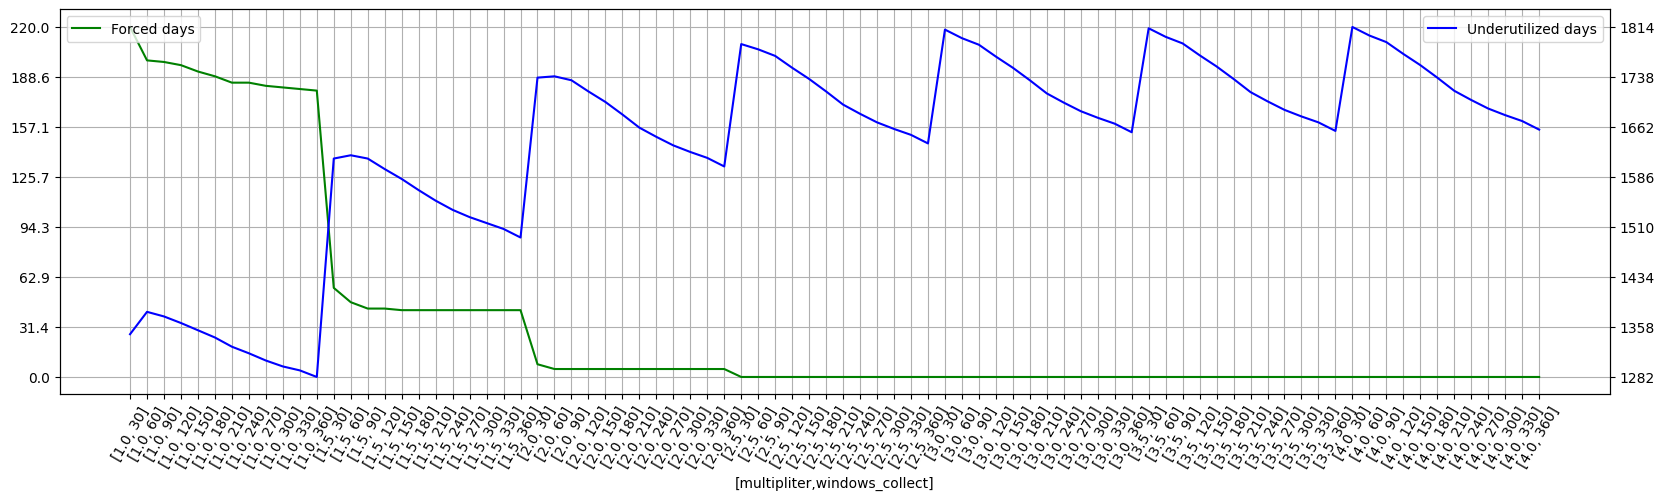

In [158]:
draw_compare_plot(count_ewma,'Parameter','Forced','Underutilized')

Days of forced liquidation : 5
Days of assets are Underutilized : 1602


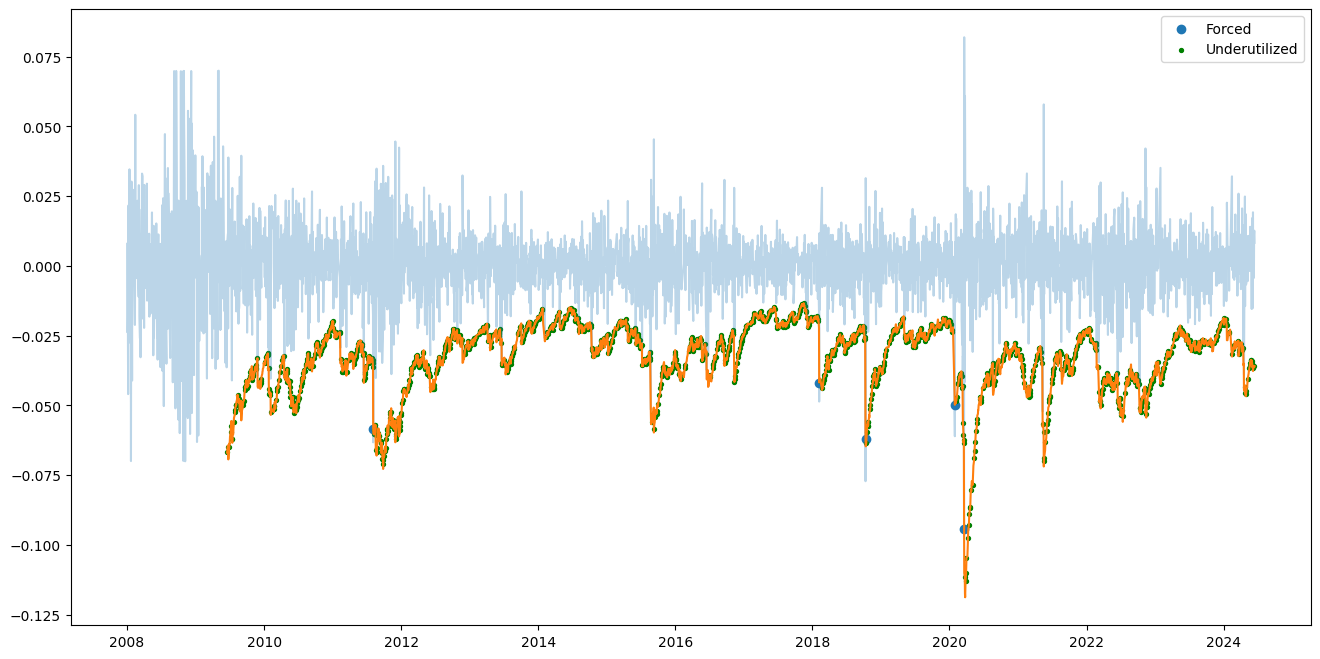

In [165]:
backtest_data,force_date,waste_date = ewma_backtest(symbol_data,confident_level=0.95,multiplier=2,window_collect=360,alpha=0.05,use_ratio=0.7)
print(f'Days of forced liquidation : {len(force_date)}')
print(f'Days of assets are Underutilized : {len(waste_date)}')
draw_plot(backtest_data,force_date,waste_date,'both')